# Reimplementation of the best performing algorithm from Killourhy and Maxion's research paper for static authentication 

Comparing Anomaly-Detection Algorithms for Keystroke Dynamics

In [1]:
import pandas as pd
import numpy as np
import sklearn as sc
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import metrics
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix

# Load Data

In [3]:
def load_dataset(name):
    data = pd.read_csv(name)

    if len(data.columns) > 12:
        # Original dataset
        data = data[data.columns.drop(list(data.filter(regex='H')))]
        data = data[data.columns.drop(list(data.filter(regex='UD')))]

        data_columns = data[data.columns.drop(['sessionIndex', 'rep', 'subject'])].columns
        data = data[data.columns.drop(['sessionIndex', 'rep'])]
        data["subject"] = data["subject"].apply(lambda x: int(x[1:]))

    else:
        # Network dataset
        data = data[data.columns.drop(['Unnamed: 0'])]

    return data


# Original dataset
# data = load_dataset("datasets/killourhy_maxion_password.csv")

# Network dataset
data = load_dataset("network_gns3/data_over_network_0_latency_0_jitter.csv")

In [4]:
## Original data
#
# data = pd.read_csv("../datasets/Fixed/killourhy_maxion_password.csv")
# data["subject"] = data["subject"].apply(lambda x: int(x[1:]))
subjects = data.subject.unique().tolist()


# data = data[data.columns.drop(list(data.filter(regex='H')))]
# data = data[data.columns.drop(list(data.filter(regex='UD')))]
# data = data[data.columns.drop(['sessionIndex', 'rep'])]
# data.head()

In [5]:
## Network data

# data = pd.read_csv("data_over_network.csv")

In [6]:
s_id = 2

# create dataset of this user
s = data[data["subject"] == s_id]
X = s[s.columns.drop(['subject'])]

# divide between train and test
X_train = X.head(200)
X_test = X.tail(200)


# NN Mahalanobis

In [7]:
from sklearn.covariance import MinCovDet

# robust_cov = MinCovDet().fit(X)
# print(robust_cov.covariance_)
# V = robust_cov.covariance_

In [8]:
from sklearn.covariance import EmpiricalCovariance

# emp_cov = EmpiricalCovariance().fit(X_train)
# print(emp_cov.covariance_)
# V = emp_cov.covariance_

In [9]:
# # calculate covariance matrix
# V = np.cov(X_train, rowvar=False)
# print(V)

In [88]:
# # By hand covariance
#
# N = X_train.shape[1]
# X = X_train.to_numpy()
# X -= X.mean(axis=0)
# fact = N - 1
# by_hand = np.dot(X.T, X.conj()) / fact
#
# print(by_hand)
# V = by_hand

In [10]:
V = pd.DataFrame.cov(X_train)
print(V)

                 DD.period.t    DD.t.i    DD.i.e  DD.e.five  DD.five.Shift.r  \
DD.period.t         0.007079  0.000546  0.000921   0.006856         0.003818   
DD.t.i              0.000546  0.001213  0.000286   0.000528        -0.000598   
DD.i.e              0.000921  0.000286  0.005502   0.004280         0.000866   
DD.e.five           0.006856  0.000528  0.004280   0.054531         0.021041   
DD.five.Shift.r     0.003818 -0.000598  0.000866   0.021041         0.050671   
DD.Shift.r.o        0.002536 -0.000008  0.000838   0.014649         0.015032   
DD.o.a              0.000039  0.000106 -0.000029   0.001961         0.001755   
DD.a.n              0.001101  0.000165  0.000081   0.005821         0.002813   
DD.n.l              0.000102 -0.000066  0.000033   0.002865         0.003547   
DD.l.Return         0.001252 -0.000066  0.000518   0.009462         0.005991   

                 DD.Shift.r.o    DD.o.a    DD.a.n    DD.n.l  DD.l.Return  
DD.period.t          0.002536  0.000039  0.0

In [12]:
# training phase of detector
# nn = NearestNeighbors(n_neighbors=1, metric='mahalanobis', metric_params={'V' : V})
# nn = NearestNeighbors(n_neighbors=1, metric='mahalanobis', metric_params={'V' : V}, algorithm='brute')
# nn = NearestNeighbors(n_neighbors=1, metric='mahalanobis', metric_params={'VI' : np.linalg.inv(V)}, algorithm='brute')
nn = NearestNeighbors(n_neighbors=1, metric='mahalanobis', metric_params={'V' : V, 'VI' : np.linalg.inv(V)}, algorithm='brute')
nn.fit(X_train)

# test phase of detector of user
anomaly_user_score, indices = nn.kneighbors(X_test)

In [13]:
print(anomaly_user_score)

[[0.83979184]
 [0.63904676]
 [2.01495521]
 [1.0006913 ]
 [0.98427869]
 [0.99153883]
 [0.7180197 ]
 [1.13198164]
 [0.82195393]
 [2.0060822 ]
 [0.82843092]
 [2.02678586]
 [2.52849684]
 [1.48581353]
 [1.31584316]
 [1.01955145]
 [1.26442182]
 [1.16431661]
 [0.9399775 ]
 [3.76087697]
 [1.13722239]
 [1.6741814 ]
 [0.93565478]
 [2.05022973]
 [2.68363213]
 [4.19499543]
 [0.77347151]
 [1.99716642]
 [0.94523133]
 [2.69272075]
 [1.00854053]
 [1.20765674]
 [1.55537921]
 [1.14364446]
 [0.919684  ]
 [0.71424808]
 [0.91123316]
 [0.87937798]
 [0.59618169]
 [0.57240116]
 [0.56749826]
 [1.16887463]
 [1.26264391]
 [1.38002135]
 [1.57277297]
 [6.07534316]
 [1.24896414]
 [1.79330358]
 [1.06301223]
 [0.92040633]
 [1.11601283]
 [0.90795735]
 [0.93946314]
 [1.36480185]
 [1.41352187]
 [1.53482686]
 [1.15516661]
 [1.02557005]
 [1.04286584]
 [0.6651518 ]
 [1.53429872]
 [1.35520328]
 [1.22728026]
 [1.11683225]
 [1.6471613 ]
 [1.22419058]
 [1.34098613]
 [2.26691056]
 [0.37433655]
 [1.2477472 ]
 [1.13114277]
 [1.32

Multiple impostors

In [14]:
# test phase of detector of impostor
i = 0

subjects_to_iterate = subjects
subjects_to_iterate.remove(s_id)
print(subjects_to_iterate)

[3, 4, 5, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [16]:
anomaly_impostor_score = []
for x in subjects_to_iterate:

    # get impostor dataframe
    si = data[data["subject"] == x]
    Xi = si[si.columns.drop(['subject'])]
    Xi_test = Xi.head(5)

    # test the first five

    ## Nearest Neighbor
    tmp_impostor_score, indices = nn.kneighbors(Xi_test)

    # record the results
    # if it is the first time, save it as base
    if i == 0:
        anomaly_impostor_score = tmp_impostor_score
    # append it to existing if not the first one
    else:
        anomaly_impostor_score = np.append(anomaly_impostor_score, tmp_impostor_score)

    i = i +1

In [17]:
print(anomaly_impostor_score)

[  2.3532842    2.29481093   2.98829834  14.46996361   4.96217679
   2.72947283   3.47615098   3.88080066   2.5678486    1.98179769
  21.07651427   9.52731027  16.30945786   8.73844633   7.39885186
   5.34395787   7.15191141   5.17386473   4.64486954   3.18525568
   3.61787154   3.33600339   2.44184823   2.97205687   1.69583419
   1.65523882   5.61229347   4.04694295   1.44232463   0.87142826
   2.5366701    1.20999142   1.86837307   3.14985426   2.44543781
   3.47902036   3.19538998   2.74681533  13.5789552    5.32657777
   5.27636784   0.89651052   3.58056441   4.84802985   2.06617583
   3.07928929   2.26516984   2.84057108   2.80802816   2.66889593
   7.96717799   9.29330238   4.90901786   8.42139474   4.75006944
   1.82363736   3.37453933   1.86626118   1.32087397   3.26008617
   6.3244612    5.13303447   7.89340451   6.46480574   3.22620232
  13.243833     9.55248739   8.80180536  11.20928014   6.91497134
  32.08154584   4.71400509   3.96083081   1.47739961   1.09828628
  15.84209

## Threshold for acceptance

Assuming Gaussian distribution

In [18]:
user_mean = np.mean(anomaly_user_score)
user_std = np.std(anomaly_user_score)
user_min = np.min(anomaly_user_score)
user_max = np.max(anomaly_user_score)

impostor_mean = np.mean(anomaly_impostor_score)
impostor_std = np.std(anomaly_impostor_score)
impostor_min = np.min(anomaly_impostor_score)
impostor_max = np.max(anomaly_impostor_score)

if user_max >= impostor_max:
    plot_max = user_max
else:
    plot_max = impostor_max

if user_min <= impostor_min:
    plot_min = user_min
else:
    plot_min = impostor_min

print(plot_min)
print(plot_max)

0.37433655497038804
110.64671120303831


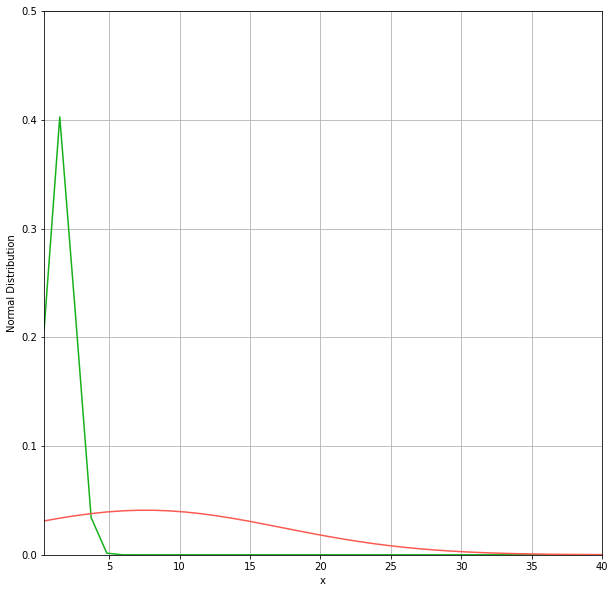

In [96]:
# Plotting
plt.figure(figsize=(10,10))

x = np.linspace(plot_min, plot_max, 100)

y_user = scipy.stats.norm.pdf(x,user_mean,user_std)
y_impostor = scipy.stats.norm.pdf(x,impostor_mean,impostor_std)

plt.plot(x,y_user, color='xkcd:green')
plt.plot(x,y_impostor, color='xkcd:coral')


plt.grid()

plt.xlim(plot_min,40)
plt.ylim(0,0.5)

plt.xlabel('x')
plt.ylabel('Normal Distribution')

# plt.savefig("normal_distribution_user_impostor.png")
plt.show()

In [19]:
fpr = [1]
tpr = [1]
threshold = [0]

# For each possible threshold
for t in np.arange(0, int(plot_max), 1):
    
    y_score = []
    y_true = []

    # False alarm rate so False Positive Rate
    # Every user mistaken as impostor
    for e in anomaly_user_score:

        # true label
        y_true.append(0)

        # print("score : " + str(e))
        # print("threshold : " + str(t))
        # score label
        if e > t:
            y_score.append(1)
        else:
            y_score.append(0)

        # print(y_score)

    # Hit Rate so True Positive Rate
    # Every impostor as user
    for e in anomaly_impostor_score:

        # true label
        y_true.append(1)

        # score label
        if e > t:
            y_score.append(1)
        else:
            y_score.append(0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    # print("True Negative : " + str(tn))
    # print("False Positive : " + str(fp))
    # print("False Negative : " + str(fn))
    # print("True Positive : " + str(tp))

    p = tp + fn
    n = fp + tn

    temp_fpr = fp / n
    temp_tpr = tp / p
    # print("False Positive Rate : " + str(fpr))
    # print("True Positive Rate : " + str(tpr))

    fpr.append(temp_fpr)
    tpr.append(temp_tpr)
    threshold.append(t)


fpr.append(0)
tpr.append(0)
threshold.append(int(plot_max))

In [20]:
print(len(fpr))
print(len(tpr))
print(len(threshold))

112
112
112


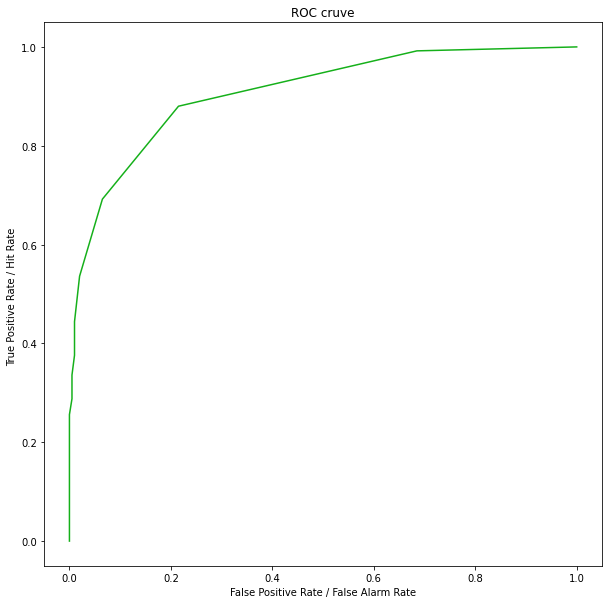

In [21]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='xkcd:green',)
plt.xlabel('False Positive Rate / False Alarm Rate')
plt.ylabel('True Positive Rate / Hit Rate ')
plt.title('ROC cruve')
# plt.savefig('user_original.png')
plt.savefig('user_network.png')
plt.show()

In [22]:
# Calculate EER

# TODO: is this correct manner ?
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, threshold)(eer)

print(eer)
# print(thresh)

0.1728402366863905


In [23]:
# Calculate the zero-miss false-alarm rate

# This is when the Hit Rate is equal 1 / Miss Rate is 0

for index, val in enumerate(tpr):
    # print(val)
    if val == 1:
        zero_miss_false_alarm = fpr[index]

print(zero_miss_false_alarm)

1.0
